## this is purely for tranforming the data and training and testing models

In [1]:
#import libraries
import sqlite3
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import math
#connect to the data.db database
conn = sqlite3.connect('data.db')
cursor = conn.cursor()

In [2]:
#importing all the tables in the database
outcomes_df = pd.read_sql_query("select * from Outcomes", conn)
clients_df = pd.read_sql_query("select * from Clients", conn)
campaigns_df = pd.read_sql_query("select * from Campaigns", conn)
accounts_df = pd.read_sql_query("select * from Accounts", conn)

In [3]:
#joining the tables based on foreign keys
query = """
SELECT
c.id AS client_id,
c.age,
c.job,
c.marital,
c.education,
a.balance,
a.in_default,
a.housing,
a.loan,
ca.duration,
ca.campaign,
ca.pdays,
ca.previous,
o.poutcome,
o.y
FROM Clients c
JOIN Accounts a ON c.id = a.client_id
JOIN Campaigns ca ON a.id = ca.account_id
JOIN Outcomes o ON ca.id = o.campaign_id;
"""

# Execute the query and fetch the result into a DataFrame
merged_df = pd.read_sql_query(query, conn)
merged_df

,client_id,age,job,marital,education,balance,in_default,housing,loan,duration,campaign,pdays,previous,poutcome,y
0,4815378,58,management,married,tertiary,2143.0,no,yes,no,261,1,-1,0,unknown,unknown
1,5217541,44,technician,single,secondary,29.0,no,yes,no,151,1,-1,0,unknown,unknown
2,6654642,33,entrepreneur,married,secondary,2.0,no,yes,yes,76,1,-1,0,unknown,unknown
3,1421898,47,blue-collar,married,unknown,1506.0,no,yes,no,92,1,-1,0,unknown,unknown
4,2387933,33,unknown,single,unknown,1.0,no,no,no,198,1,-1,0,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,6145087,51,technician,married,tertiary,825.0,no,no,no,977,3,-1,0,unknown,unknown
45207,8051149,71,retired,divorced,primary,1729.0,no,no,no,456,2,-1,0,unknown,unknown
45208,9198356,72,retired,married,secondary,5715.0,no,no,no,1127,5,184,3,success,unknown
45209,3187020,57,blue-collar,married,secondary,668.0,no,no,no,508,4,-1,0,unknown,unknown


In [4]:
#picking out rows where they said subscribed to deposit and did not and also unknown values
condition = (merged_df.y == 'yes') | (merged_df.y =='no')
condition2 = (merged_df.y=='unknown') 
y_with_outcome = merged_df[condition]
y_unknown = merged_df[condition2] #unknown


In [5]:
# Define the conditions for categorizing ages
conditions = [
    merged_df['age'] < 35,
    (merged_df['age'] >= 35) & (merged_df['age'] < 60),
    merged_df['age'] >= 60
]

# Define the corresponding categories
choices = ['young', 'middle', 'old']

# Apply the conditions and create a new column for age categories
merged_df['age_category'] = np.select(conditions, choices, default='unknown')
merged_df = merged_df.drop(['age'],axis=1)

In [6]:
merged_df.columns

Index(['client_id', 'job', 'marital', 'education', 'balance', 'in_default',
       'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y', 'age_category'],
      dtype='object')

In [7]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select the columns to be one-hot encoded
columns_to_encode = ['job', 'education','marital','poutcome','age_category']  # Fix: Separate the column names into a list

# Initialize the OneHotEncoder
ohe_encoder = OneHotEncoder(handle_unknown='ignore')  # drop='first' avoids the dummy variable trap

# Apply the encoder to the specified columns
encoded_data = ohe_encoder.fit_transform(merged_df[columns_to_encode])

# Convert the encoded data to a DataFrame
encoded_columns = ohe_encoder.get_feature_names_out(columns_to_encode)

# Convert the sparse matrix to a dense array
encoded_dense = encoded_data.toarray()

# Create a DataFrame from the dense array with appropriate column names
encoded_df = pd.DataFrame(encoded_dense, columns=encoded_columns)
encoded_df.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'age_category_middle',
       'age_category_old', 'age_category_young'],
      dtype='object')

In [8]:
# Reset index for both DataFrames
merged_df = merged_df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Perform horizontal concatenation
horizontal_concat = pd.concat([merged_df, encoded_df], axis=1)
ohe_df = horizontal_concat
ohe_df = ohe_df.drop(['job', 'education','marital','poutcome','age_category'], axis=1)

In [9]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

ohe_df['housing'] = label_encoder.fit_transform(ohe_df['housing'])
print('HOUSING converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

ohe_df['loan'] = label_encoder.fit_transform(ohe_df['loan'])
print('LOAN converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

ohe_df['y'] = label_encoder.fit_transform(ohe_df['y'])
print('Y converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

HOUSING converted to number: 
{'no': 0, 'yes': 1}

--------------------------------
LOAN converted to number: 
{'no': 0, 'yes': 1}

--------------------------------
Y converted to number: 
{'no': 0, 'unknown': 1, 'yes': 2}

--------------------------------


In [10]:
#transforming values into log scale to deal with outliers
ohe_df['duration'] = ohe_df['duration'].apply(
    lambda x: 0 if x <=0 else
              np.log(1+x)  )
print('DURATION made logaritmic (zero for balance <1): ')
print()
print('--------------------------------')

ohe_df['balance'] = ohe_df['balance'].apply(
    lambda x: 0 if x <=0 else
              np.log(1+x)  )
print('BALANCE made logaritmic (zero for balance <1): ')
print()
print('--------------------------------')

columns_transform = ['balance','duration','campaign','pdays','previous']
scaler = MinMaxScaler()
ohe_df[columns_transform] = scaler.fit_transform(ohe_df[columns_transform])
ohe_df

DURATION made logaritmic (zero for balance <1): 

--------------------------------
BALANCE made logaritmic (zero for balance <1): 

--------------------------------


,client_id,balance,in_default,housing,loan,duration,campaign,pdays,previous,y,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
0,4815378,0.665029,no,1,0,0.655033,0.000000,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,5217541,0.294885,no,1,0,0.590985,0.000000,0.000000,0.000000,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,6654642,0.095250,no,1,1,0.510984,0.000000,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1421898,0.634462,no,1,0,0.533193,0.000000,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2387933,0.060096,no,0,0,0.622679,0.000000,0.000000,0.000000,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,6145087,0.582331,no,0,0,0.809978,0.032258,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
45207,8051149,0.646427,no,0,0,0.720478,0.016129,0.000000,0.000000,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
45208,9198356,0.750047,no,0,0,0.826764,0.064516,0.212156,0.010909,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45209,3187020,0.564054,no,0,0,0.733155,0.048387,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [11]:
ohe_df.columns

Index(['client_id', 'balance', 'in_default', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_category_middle', 'age_category_old',
       'age_category_young'],
      dtype='object')

In [12]:
#splitting ohe_df based on y knowns and y unknowns
condition = (ohe_df.y == 2) | (ohe_df.y ==0)
y_known = ohe_df[condition]
y_known = y_known.drop(['in_default'], axis=1)
y_known

,client_id,balance,housing,loan,duration,campaign,pdays,previous,y,job_admin.,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
7,5561468,0.095250,1,0,0.699082,0.000000,0.000000,0.000000,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
9,5203129,0.553745,1,0,0.473523,0.000000,0.000000,0.000000,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
14,6633578,0.441630,1,0,0.607560,0.000000,0.000000,0.000000,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
30,9718018,0.583788,0,1,0.637645,0.000000,0.000000,0.000000,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
33,1174906,0.000000,1,0,0.638165,0.000000,0.000000,0.000000,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45160,4645105,0.000000,1,0,0.736796,0.000000,0.111239,0.018182,2,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
45173,2354794,0.597241,0,0,0.562193,0.048387,0.120413,0.025455,0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
45191,9424440,0.714900,1,0,0.655481,0.000000,0.211009,0.003636,2,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
45197,2721327,0.634749,1,0,0.659006,0.000000,0.000000,0.000000,2,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [27]:
#splitting ohe_df based on y knowns and y unknowns
condition2= (ohe_df.y == 1)
y_unknown = ohe_df[condition2]
y_unknown = y_unknown.drop(['y','in_default'], axis=1)
y_unknown.to_csv("prediction_df")

In [28]:
y_unknown.shape

(40690, 34)

In [14]:
#splitting dataset into test and train sets
columns_in_df = ohe_df.columns
X = y_known[['balance', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_category_middle', 'age_category_old',
       'age_category_young']]
y = y_known["y"]
y[y==2]=1
X.shape, y.shape

X.to_csv("X.csv")
y.to_csv("y.csv")

C:\Users\rukhm\AppData\Local\Temp\ipykernel_26724\1017467758.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y==2]=1


In [15]:
from sklearn import svm 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Check shapes after conversion
print(y_train.shape)  # Should now be (3616,)
print(y_test.shape)   # Should now be (905,)

(3616,)
(905,)


In [17]:
# # 2. Initialize the SVM model
# svm_model = SVC(
#     C=1000,
#     kernel='rbf',           # Radial Basis Function kernel (default)
#     class_weight='balanced' # Handle class imbalance
# )


In [18]:
# # 3. Fit the model to the training data
# svm_model.fit(X_train, y_train)

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train logistic regression on the balanced dataset
rf_classifier = RandomForestClassifier(max_depth= 7, min_samples_leaf=10, min_samples_split= 8, n_estimators= 49, random_state=42)
rf_model = rf_classifier.fit(X_train, y_train)

In [20]:
from sklearn.metrics import classification_report, roc_auc_score
# Predict on the test set
y_pred = rf_model.predict(X_test)
classification_report_test_group = classification_report(y_test, y_pred, output_dict=True)
# Evaluate the model
print("\nClassification Report from test group:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Feature Importance
print("\n-------------------------------------")
print("Feature Importance:")
importance = rf_model.feature_importances_
columns = ['balance', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_category_middle', 'age_category_old',
       'age_category_young']
for i, feature in enumerate(columns):
    print(f"{feature}: {importance[i]:.4f}")

y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc






Classification Report from test group:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       797
           1       0.73      0.10      0.18       108

    accuracy                           0.89       905
   macro avg       0.81      0.55      0.56       905
weighted avg       0.87      0.89      0.85       905


Accuracy Score: 0.8883977900552487

-------------------------------------
Feature Importance:
balance: 0.0584
housing: 0.0252
loan: 0.0076
duration: 0.4519
campaign: 0.0158
pdays: 0.0639
previous: 0.0565
job_admin.: 0.0015
job_blue-collar: 0.0088
job_entrepreneur: 0.0013
job_housemaid: 0.0003
job_management: 0.0038
job_retired: 0.0200
job_self-employed: 0.0004
job_services: 0.0006
job_student: 0.0022
job_technician: 0.0024
job_unemployed: 0.0002
job_unknown: 0.0001
education_primary: 0.0032
education_secondary: 0.0070
education_tertiary: 0.0109
education_unknown: 0.0009
marital_divorced: 0.0070
marital_married: 0.0126
marita

0.868174636367861

In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sample data creation (replace this with your actual DataFrame)
np.random.seed(42)

# Separate features and target variable
X = train_and_test_df[prediction_df.columns.drop("client_id")]
y = train_and_test_df["y"] == "yes"

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing: Encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

# Create a pipeline that includes preprocessing and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1],
    'classifier__colsample_bytree': [0.8, 1],
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2
)

# Fit the model using grid search
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]


NameError: name 'train_and_test_df' is not defined

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming your preprocessed and split data are named as follows:
# X_train, X_val, y_train, y_val

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit the model using grid search
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation ROC AUC: {roc_auc:.4f}')


Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\anaconda\envs\dwwshop\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Validation Accuracy: 0.8895
Validation ROC AUC: 0.8677


In [ ]:
def total_return(num_reached, balances, alpha=0.1): 
    return -2 * num_reached + alpha * sum(balances)
# -2 * num_reached: This represents the cost of reaching out to num_reached individuals.
# calculates the total balance (or value) associated with the individuals reached.
# 
def avg_return(num_reached, balances, alpha=0.1):
    return total_return(num_reached, balances, alpha) / num_reached

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
reached_customers = X_test.loc[y_pred == 1] 
converted_customers = X_test.loc[(y_pred == 1) & (y_test == 1)]
num_reached = len(reached_customers)
num_converted = len(converted_customers)
conversion_ratio = num_converted / num_reached
expected_avg_return = avg_return(num_reached, reached_customers["balance"])
actual_avg_return = avg_return(num_reached, converted_customers["balance"])
return_ratio = actual_avg_return / expected_avg_return
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation ROC AUC: {roc_auc:.4f}')
print(f"Number of reached customers", num_reached)
print(f"Number of converted customers", num_converted)
print(f"Expected avg return", expected_avg_return)
print(f"Actual avg return", actual_avg_return)
print("Conversion ratio", conversion_ratio)
print("Avg return ratio", return_ratio)

Validation Accuracy: 0.8884
Validation ROC AUC: 0.8677
Number of reached customers 15
Number of converted customers 11
Expected avg return -1.9496900655838496
Actual avg return -1.9617957510068174
Conversion ratio 0.7333333333333333
Avg return ratio 1.0062090306744946


In [ ]:
X

In [ ]:
# Make predictions
X_future = y_unknown.drop('client_id', axis=1)
y_future = rf_model.predict(X_future)

In [ ]:
alpha = 0.05
expected_avg_return = avg_return(num_reached, reached_customers["balance"], alpha=alpha)
actual_avg_return = avg_return(num_reached, converted_customers["balance"], alpha=alpha)
return_ratio = abs(actual_avg_return / expected_avg_return)
    #if actual_avg_return < 0 or expected_avg_return < 0:
    #  return_ratio = 1

future_reached_customers = X_future.loc[y_future == 1]
future_num_reached = len(future_reached_customers)
future_expected_avg_return = avg_return(future_num_reached, future_reached_customers["balance"], alpha=alpha)
print(alpha, 
    future_expected_avg_return * return_ratio,
    sep="\t")

0.05	-1.977101041851278


In [ ]:
client_ids_to_reach = y_unknown.loc[y_future == 1, "client_id"].copy()
client_ids_to_reach.name = "target"
client_ids_to_reach.to_csv("second_phase_target_v2.csv", index=False)

In [ ]:
csv1 = pd.read_csv("second_phase_target.csv")
csv2= pd.read_csv("second_phase_target_v2.csv")

In [ ]:
# Specify the column you want to compare
column_to_check = 'target'  # Replace with the actual column name

# Ensure the column exists in both DataFrames
if column_to_check not in csv1.columns or column_to_check not in csv2.columns:
    raise KeyError(f"Column '{column_to_check}' must exist in both CSV files.")

# Find the values in csv2 that are also in csv1
common_values = csv2[csv2[column_to_check].isin(csv1[column_to_check])]

# Display the common values
print("Values in csv2 that are also in csv1:")
print(common_values)


Values in csv2 that are also in csv1:
      target
0    7170052
1    4926256
2    6370783
3    7514671
4    8621194
..       ...
729  3425063
730  7880822
732  4565593
733  9219966
734  9198356

[609 rows x 1 columns]


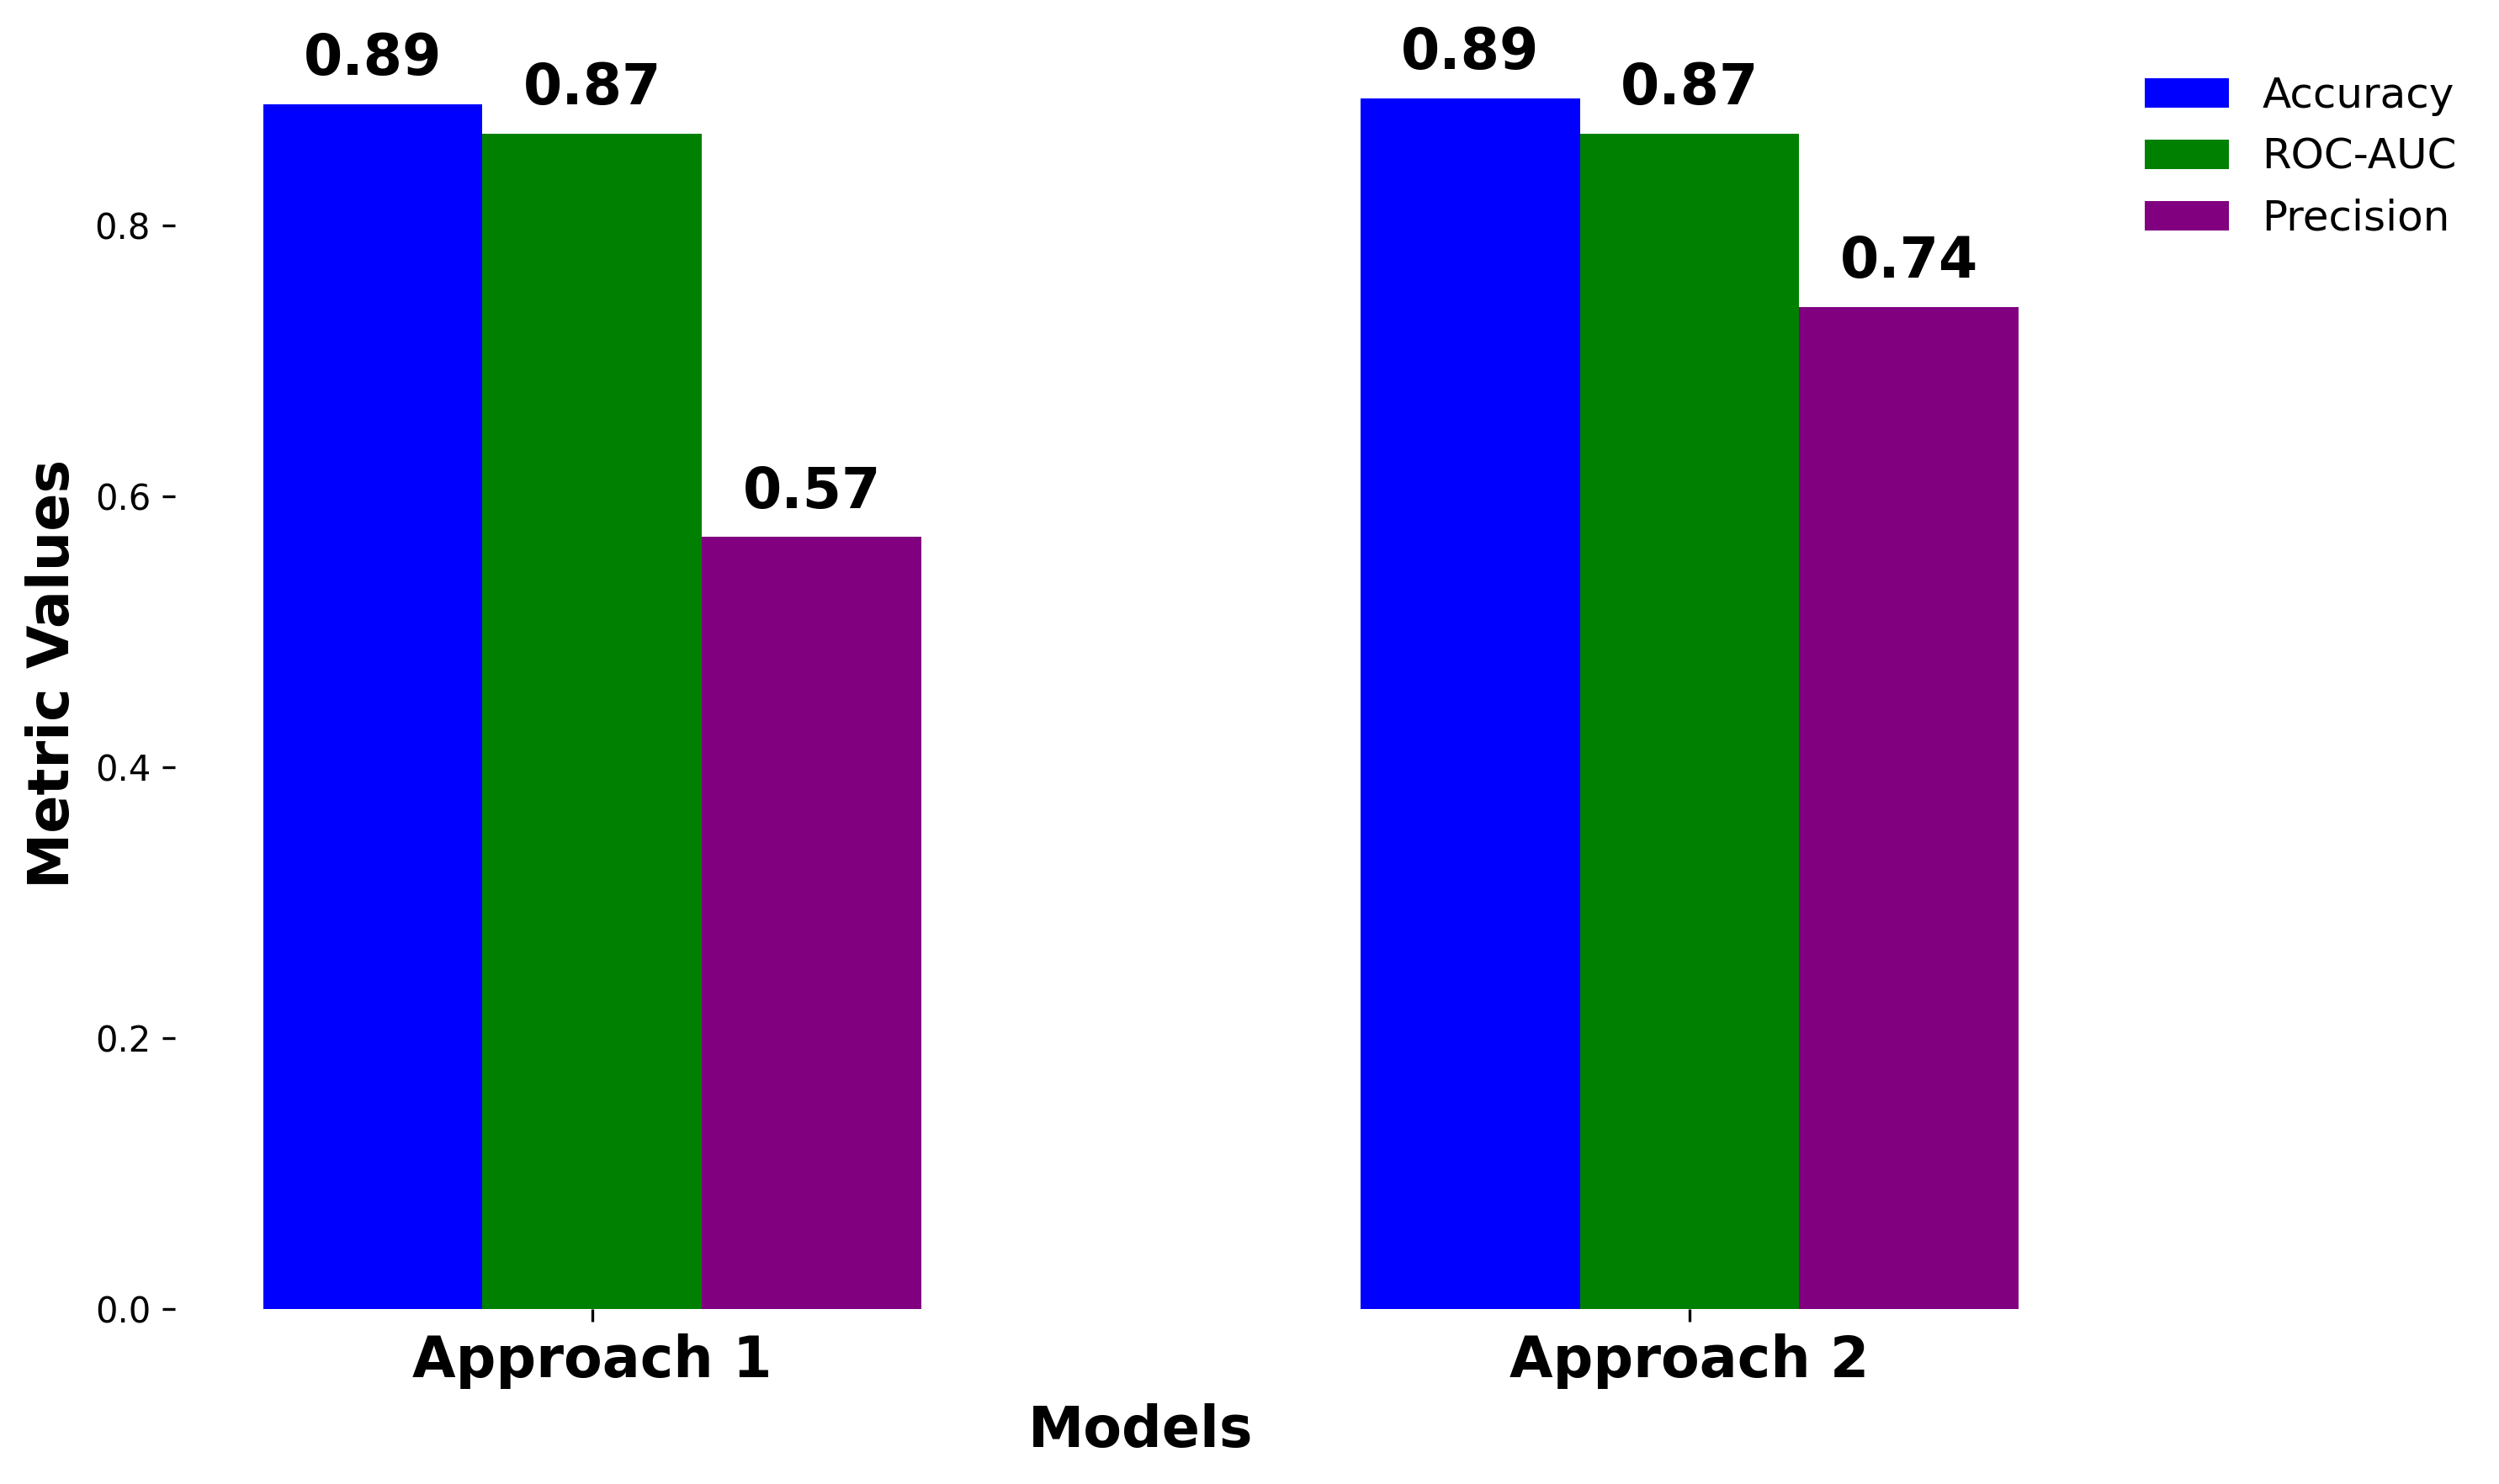

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics for each model
models = ['Approach 1', 'Approach 2']
accuracy = [0.8895, 0.894]
roc_auc = [0.8677, 0.868]
Precision = [0.57, 0.74]

# Create a side-by-side bar chart for the metrics
x = np.arange(len(models))  # Label locations
width = 0.2  # Adjusted width of each bar

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Combine bars from both approaches on one side
bars1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='blue')
bars2 = ax.bar(x, roc_auc, width, label='ROC-AUC', color='green')
bars3 = ax.bar(x + width, Precision, width, label='Precision', color='purple')

# Adding labels, title, and legend
ax.set_xlabel('Models', fontsize=16, fontweight='bold')
ax.set_ylabel('Metric Values', fontsize=16, fontweight='bold')
#ax.set_title('Comparison of Approach 1 (XGBoost) and Approach 2 (Random Forest)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=16, fontweight='bold')
ax.spines[:].set_visible(False)

# Positioning the legend outside the figure
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Adding enlarged value labels on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points", ha='center', va='bottom',
                    fontsize=16, fontweight='bold', color='black')

plt.tight_layout()
plt.show()
